# Experiment 1

### Two point crossover

* Run 1

In [3]:
#!pip install opencv-python-headless

c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Run 1


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 139   2]
 [ 57  48  41]
 [170 170 170]
 [249 196 127]
 [232 226 212]
 [230 145  40]
 [161  97  18]
 [108 108 108]]
Generation 1, Best Fitness: 0.47062663165704943
Generation 2, Best Fitness: 0.47062663165704943
Generation 3, Best Fitness: 0.46106262200187953
Generation 4, Best Fitness: 0.45170870274477715
Generation 5, Best Fitness: 0.43262800589996986
Generation 6, Best Fitness: 0.43262800589996986
Generation 7, Best Fitness: 0.425989656830714
Generation 8, Best Fitness: 0.425989656830714
Generation 9, Best Fitness: 0.4186984578832301
Generation 10, Best Fitness: 0.41015133533513515
Generation 11, Best Fitness: 0.40836947971587356
Generation 12, Best Fitness: 0.40165151222915063
Generation 13, Best Fitness: 0.39945071528697873
Generation 14, Best Fitness: 0.39019539072505083
Generation 15, Best Fitness: 0.39019539072505083
Generation 16, Best Fitness: 0.38496062039800927
Generation 17, Best Fitness: 0.382864807172943
Generation 18

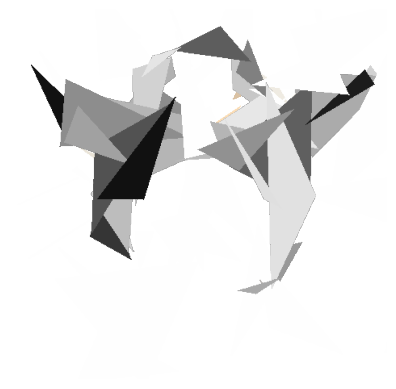

In [1]:
import random
from PIL import Image, ImageDraw
import numpy as np
from skimage.metrics import structural_similarity as ssim
from copy import deepcopy
from sklearn.cluster import KMeans
import cv2

class Color:
    def __init__(self, filename, num_colors=10):
        self.target_image = cv2.imread(filename)
        self.target_image = cv2.cvtColor(self.target_image, cv2.COLOR_BGR2RGB)
        self.height, self.width, _ = self.target_image.shape
        self.palette = self.extract_palette(self.target_image, num_colors).astype(int)
        print("Extracted palette:", self.palette)

    def extract_palette(self, image, num_colors=10):
        pixels = image.reshape((-1, 3))
        kmeans = KMeans(n_clusters=num_colors)
        kmeans.fit(pixels)
        palette = kmeans.cluster_centers_
        return palette

class Triangle:
    def __init__(self, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.palette = palette
        x = random.randint(0, img_width)
        y = random.randint(0, img_height)

        self.points = [
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50))
        ]
        self.color = self._random_color()

    def _random_color(self):
        return tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int)) + (random.randint(0, 256),)

    def mutate(self, mutation_rate=0.01):
        if random.random() < mutation_rate:
            mutation_type = random.choice(['shift', 'point', 'color', 'swap'])
            if mutation_type == 'shift':
                self.points = [(x + random.randint(-50, 50), y + random.randint(-50, 50)) for x, y in self.points]
            elif mutation_type == 'point':
                index = random.choice(range(3))
                self.points[index] = (self.points[index][0] + random.randint(-50, 50), self.points[index][1] + random.randint(-50, 50))
            elif mutation_type == 'color':
                self.color = self._random_color()
            elif mutation_type == 'swap':
                i, j = random.sample(range(3), 2)
                self.points[i], self.points[j] = self.points[j], self.points[i]

class Painting:
    def __init__(self, num_triangles, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.triangles = [Triangle(img_width, img_height, palette) for _ in range(num_triangles)]

    def draw(self) -> Image:
        image = Image.new("RGBA", (self._img_width, self._img_height), (255, 255, 255, 255))
        draw = ImageDraw.Draw(image)
        for t in self.triangles:
            draw.polygon(t.points, fill=t.color)
        return image

    def mutate(self, mutation_rate=0.01):
        for triangle in self.triangles:
            triangle.mutate(mutation_rate)

def calculate_fitness(painting, target_image):
    target_array = np.array(target_image.convert('L'))
    rendered_image = np.array(painting.draw().convert('L'))
    ssim_value = ssim(target_array, rendered_image)
    return 1 - ssim_value

def uniform_crossover(parent1, parent2, crossover_prob=0.5):
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)
    
    for i in range(len(parent1.triangles)):
        if random.random() < crossover_prob:
            child1.triangles[i], child2.triangles[i] = parent2.triangles[i], parent1.triangles[i]
    
    return child1, child2

class Population:
    def __init__(self, size, img_width, img_height, num_triangles, target_image, palette):
        self.size = size
        self.img_width = img_width
        self.img_height = img_height
        self.num_triangles = num_triangles
        self.target_image = target_image
        self.palette = palette
        self.individuals = [Painting(num_triangles, img_width, img_height, palette) for _ in range(size)]
        self.fitness = [calculate_fitness(ind, target_image) for ind in self.individuals]
        self.fitness_history = []

    def evolve(self, gens, xo_prob, mut_prob, elitism):
        for gen in range(gens):
            new_pop = []
            if elitism:
                elite = deepcopy(self.individuals[self.fitness.index(min(self.fitness))])

            while len(new_pop) < self.size:
                parent1 = self.tournament_selection()
                parent2 = self.tournament_selection()

                if random.random() < xo_prob:
                    child1, child2 = uniform_crossover(parent1, parent2)
                else:
                    child1, child2 = deepcopy(parent1), deepcopy(parent2)

                child1.mutate(mut_prob)
                child2.mutate(mut_prob)

                new_pop.extend([child1, child2])

            if elitism:
                worst_index = self.fitness.index(max(self.fitness))
                new_pop[worst_index] = elite

            self.individuals = new_pop[:self.size]
            self.fitness = [calculate_fitness(ind, self.target_image) for ind in self.individuals]
            self.fitness_history.append(min(self.fitness))

            print(f"Generation {gen + 1}, Best Fitness: {min(self.fitness)}")

    def tournament_selection(self, k=3):
        selected = random.sample(list(zip(self.individuals, self.fitness)), k)
        return min(selected, key=lambda x: x[1])[0]

# Parameters
population_size = 50
num_triangles = 100
generations = 500
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True

# File to save fitness values
fitness_file = "fitness_values.txt"

# Run the evolution process 5 times and collect fitness histories
for run in range(1):
    print(f"Run {run + 1}")
    
    # Load target image
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    # Extract palette from target image
    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    # Initialize and evolve population
    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    # Append fitness history for this run to the file
    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")


import matplotlib.pyplot as plt

# Get the best individual
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

# Convert the best individual to an image
best_image = best_individual.draw()

# Convert the image to a format suitable for plt.imshow
best_image_array = np.array(best_image)

# Display the image using Matplotlib
plt.imshow(best_image_array)
plt.axis('off')  # Turn off axis labels
plt.show()

* Run 2

Run 1


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Extracted palette: [[254 254 254]
 [ 46  33  23]
 [250 139   2]
 [180 180 180]
 [221 139  37]
 [ 77  75  72]
 [  0   0   0]
 [248 195 125]
 [236 231 215]
 [126 126 126]]
Generation 1, Best Fitness: 0.48438144730807886
Generation 2, Best Fitness: 0.47219018368419907
Generation 3, Best Fitness: 0.4708963860206171
Generation 4, Best Fitness: 0.47047007522341355
Generation 5, Best Fitness: 0.46230716829173424
Generation 6, Best Fitness: 0.4490491880692784
Generation 7, Best Fitness: 0.4362839111528509
Generation 8, Best Fitness: 0.43559455036668693
Generation 9, Best Fitness: 0.4280508539273221
Generation 10, Best Fitness: 0.41882466538867436
Generation 11, Best Fitness: 0.4082621341190915
Generation 12, Best Fitness: 0.4081674540474015
Generation 13, Best Fitness: 0.40288907249855754
Generation 14, Best Fitness: 0.396985372321323
Generation 15, Best Fitness: 0.3904581131457352
Generation 16, Best Fitness: 0.38365822456645027
Generation 17, Best Fitness: 0.377943185141017
Generation 18, Be

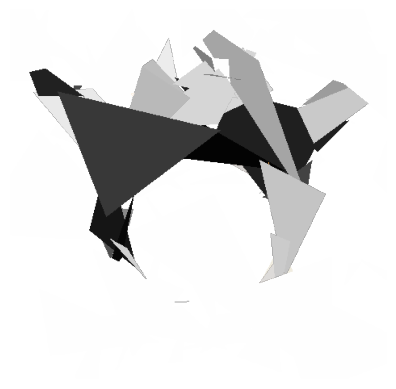

In [2]:
import random
from PIL import Image, ImageDraw
import numpy as np
from skimage.metrics import structural_similarity as ssim
from copy import deepcopy
from sklearn.cluster import KMeans
import cv2

class Color:
    def __init__(self, filename, num_colors=10):
        self.target_image = cv2.imread(filename)
        self.target_image = cv2.cvtColor(self.target_image, cv2.COLOR_BGR2RGB)
        self.height, self.width, _ = self.target_image.shape
        self.palette = self.extract_palette(self.target_image, num_colors).astype(int)
        print("Extracted palette:", self.palette)

    def extract_palette(self, image, num_colors=10):
        pixels = image.reshape((-1, 3))
        kmeans = KMeans(n_clusters=num_colors)
        kmeans.fit(pixels)
        palette = kmeans.cluster_centers_
        return palette

class Triangle:
    def __init__(self, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.palette = palette
        x = random.randint(0, img_width)
        y = random.randint(0, img_height)

        self.points = [
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50))
        ]
        self.color = self._random_color()

    def _random_color(self):
        return tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int)) + (random.randint(0, 256),)

    def mutate(self, mutation_rate=0.01):
        if random.random() < mutation_rate:
            mutation_type = random.choice(['shift', 'point', 'color', 'swap'])
            if mutation_type == 'shift':
                self.points = [(x + random.randint(-50, 50), y + random.randint(-50, 50)) for x, y in self.points]
            elif mutation_type == 'point':
                index = random.choice(range(3))
                self.points[index] = (self.points[index][0] + random.randint(-50, 50), self.points[index][1] + random.randint(-50, 50))
            elif mutation_type == 'color':
                self.color = self._random_color()
            elif mutation_type == 'swap':
                i, j = random.sample(range(3), 2)
                self.points[i], self.points[j] = self.points[j], self.points[i]

class Painting:
    def __init__(self, num_triangles, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.triangles = [Triangle(img_width, img_height, palette) for _ in range(num_triangles)]

    def draw(self) -> Image:
        image = Image.new("RGBA", (self._img_width, self._img_height), (255, 255, 255, 255))
        draw = ImageDraw.Draw(image)
        for t in self.triangles:
            draw.polygon(t.points, fill=t.color)
        return image

    def mutate(self, mutation_rate=0.01):
        for triangle in self.triangles:
            triangle.mutate(mutation_rate)

def calculate_fitness(painting, target_image):
    target_array = np.array(target_image.convert('L'))
    rendered_image = np.array(painting.draw().convert('L'))
    ssim_value = ssim(target_array, rendered_image)
    return 1 - ssim_value

def uniform_crossover(parent1, parent2, crossover_prob=0.5):
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)
    
    for i in range(len(parent1.triangles)):
        if random.random() < crossover_prob:
            child1.triangles[i], child2.triangles[i] = parent2.triangles[i], parent1.triangles[i]
    
    return child1, child2

class Population:
    def __init__(self, size, img_width, img_height, num_triangles, target_image, palette):
        self.size = size
        self.img_width = img_width
        self.img_height = img_height
        self.num_triangles = num_triangles
        self.target_image = target_image
        self.palette = palette
        self.individuals = [Painting(num_triangles, img_width, img_height, palette) for _ in range(size)]
        self.fitness = [calculate_fitness(ind, target_image) for ind in self.individuals]
        self.fitness_history = []

    def evolve(self, gens, xo_prob, mut_prob, elitism):
        for gen in range(gens):
            new_pop = []
            if elitism:
                elite = deepcopy(self.individuals[self.fitness.index(min(self.fitness))])

            while len(new_pop) < self.size:
                parent1 = self.tournament_selection()
                parent2 = self.tournament_selection()

                if random.random() < xo_prob:
                    child1, child2 = uniform_crossover(parent1, parent2)
                else:
                    child1, child2 = deepcopy(parent1), deepcopy(parent2)

                child1.mutate(mut_prob)
                child2.mutate(mut_prob)

                new_pop.extend([child1, child2])

            if elitism:
                worst_index = self.fitness.index(max(self.fitness))
                new_pop[worst_index] = elite

            self.individuals = new_pop[:self.size]
            self.fitness = [calculate_fitness(ind, self.target_image) for ind in self.individuals]
            self.fitness_history.append(min(self.fitness))

            print(f"Generation {gen + 1}, Best Fitness: {min(self.fitness)}")

    def tournament_selection(self, k=3):
        selected = random.sample(list(zip(self.individuals, self.fitness)), k)
        return min(selected, key=lambda x: x[1])[0]

# Parameters
population_size = 50
num_triangles = 100
generations = 500
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True

# File to save fitness values
fitness_file = "fitness_values.txt"

# Run the evolution process 5 times and collect fitness histories
for run in range(1):
    print(f"Run {run + 1}")
    
    # Load target image
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    # Extract palette from target image
    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    # Initialize and evolve population
    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    # Append fitness history for this run to the file
    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")


import matplotlib.pyplot as plt

# Get the best individual
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

# Convert the best individual to an image
best_image = best_individual.draw()

# Convert the image to a format suitable for plt.imshow
best_image_array = np.array(best_image)

# Display the image using Matplotlib
plt.imshow(best_image_array)
plt.axis('off')  # Turn off axis labels
plt.show()

Run 1


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 139   2]
 [129 129 128]
 [ 78  76  73]
 [183 183 183]
 [248 195 125]
 [221 139  37]
 [238 233 216]
 [ 46  34  24]]
Generation 1, Best Fitness: 0.4830407147287412
Generation 2, Best Fitness: 0.48045097938284076
Generation 3, Best Fitness: 0.4664646747631366
Generation 4, Best Fitness: 0.4653339330126527
Generation 5, Best Fitness: 0.45485360676916375
Generation 6, Best Fitness: 0.444444478140947
Generation 7, Best Fitness: 0.444444478140947
Generation 8, Best Fitness: 0.43605589410140133
Generation 9, Best Fitness: 0.43605589410140133
Generation 10, Best Fitness: 0.4313428781973202
Generation 11, Best Fitness: 0.4207045234817818
Generation 12, Best Fitness: 0.4162071375429347
Generation 13, Best Fitness: 0.4140140880984019
Generation 14, Best Fitness: 0.411683380032146
Generation 15, Best Fitness: 0.4080594038424812
Generation 16, Best Fitness: 0.40430375330888846
Generation 17, Best Fitness: 0.39660100799626796
Generation 18, Best 

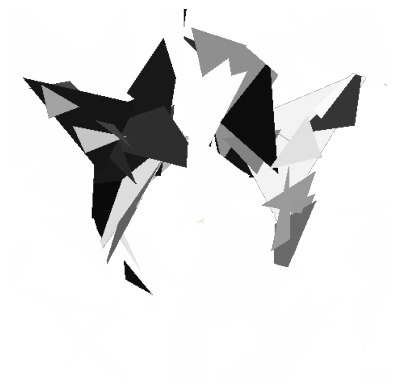

In [3]:
import random
from PIL import Image, ImageDraw
import numpy as np
from skimage.metrics import structural_similarity as ssim
from copy import deepcopy
from sklearn.cluster import KMeans
import cv2

class Color:
    def __init__(self, filename, num_colors=10):
        self.target_image = cv2.imread(filename)
        self.target_image = cv2.cvtColor(self.target_image, cv2.COLOR_BGR2RGB)
        self.height, self.width, _ = self.target_image.shape
        self.palette = self.extract_palette(self.target_image, num_colors).astype(int)
        print("Extracted palette:", self.palette)

    def extract_palette(self, image, num_colors=10):
        pixels = image.reshape((-1, 3))
        kmeans = KMeans(n_clusters=num_colors)
        kmeans.fit(pixels)
        palette = kmeans.cluster_centers_
        return palette

class Triangle:
    def __init__(self, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.palette = palette
        x = random.randint(0, img_width)
        y = random.randint(0, img_height)

        self.points = [
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50))
        ]
        self.color = self._random_color()

    def _random_color(self):
        return tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int)) + (random.randint(0, 256),)

    def mutate(self, mutation_rate=0.01):
        if random.random() < mutation_rate:
            mutation_type = random.choice(['shift', 'point', 'color', 'swap'])
            if mutation_type == 'shift':
                self.points = [(x + random.randint(-50, 50), y + random.randint(-50, 50)) for x, y in self.points]
            elif mutation_type == 'point':
                index = random.choice(range(3))
                self.points[index] = (self.points[index][0] + random.randint(-50, 50), self.points[index][1] + random.randint(-50, 50))
            elif mutation_type == 'color':
                self.color = self._random_color()
            elif mutation_type == 'swap':
                i, j = random.sample(range(3), 2)
                self.points[i], self.points[j] = self.points[j], self.points[i]

class Painting:
    def __init__(self, num_triangles, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.triangles = [Triangle(img_width, img_height, palette) for _ in range(num_triangles)]

    def draw(self) -> Image:
        image = Image.new("RGBA", (self._img_width, self._img_height), (255, 255, 255, 255))
        draw = ImageDraw.Draw(image)
        for t in self.triangles:
            draw.polygon(t.points, fill=t.color)
        return image

    def mutate(self, mutation_rate=0.01):
        for triangle in self.triangles:
            triangle.mutate(mutation_rate)

def calculate_fitness(painting, target_image):
    target_array = np.array(target_image.convert('L'))
    rendered_image = np.array(painting.draw().convert('L'))
    ssim_value = ssim(target_array, rendered_image)
    return 1 - ssim_value

def uniform_crossover(parent1, parent2, crossover_prob=0.5):
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)
    
    for i in range(len(parent1.triangles)):
        if random.random() < crossover_prob:
            child1.triangles[i], child2.triangles[i] = parent2.triangles[i], parent1.triangles[i]
    
    return child1, child2

class Population:
    def __init__(self, size, img_width, img_height, num_triangles, target_image, palette):
        self.size = size
        self.img_width = img_width
        self.img_height = img_height
        self.num_triangles = num_triangles
        self.target_image = target_image
        self.palette = palette
        self.individuals = [Painting(num_triangles, img_width, img_height, palette) for _ in range(size)]
        self.fitness = [calculate_fitness(ind, target_image) for ind in self.individuals]
        self.fitness_history = []

    def evolve(self, gens, xo_prob, mut_prob, elitism):
        for gen in range(gens):
            new_pop = []
            if elitism:
                elite = deepcopy(self.individuals[self.fitness.index(min(self.fitness))])

            while len(new_pop) < self.size:
                parent1 = self.tournament_selection()
                parent2 = self.tournament_selection()

                if random.random() < xo_prob:
                    child1, child2 = uniform_crossover(parent1, parent2)
                else:
                    child1, child2 = deepcopy(parent1), deepcopy(parent2)

                child1.mutate(mut_prob)
                child2.mutate(mut_prob)

                new_pop.extend([child1, child2])

            if elitism:
                worst_index = self.fitness.index(max(self.fitness))
                new_pop[worst_index] = elite

            self.individuals = new_pop[:self.size]
            self.fitness = [calculate_fitness(ind, self.target_image) for ind in self.individuals]
            self.fitness_history.append(min(self.fitness))

            print(f"Generation {gen + 1}, Best Fitness: {min(self.fitness)}")

    def tournament_selection(self, k=3):
        selected = random.sample(list(zip(self.individuals, self.fitness)), k)
        return min(selected, key=lambda x: x[1])[0]

# Parameters
population_size = 50
num_triangles = 100
generations = 500
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True

# File to save fitness values
fitness_file = "fitness_values.txt"

# Run the evolution process 5 times and collect fitness histories
for run in range(1):
    print(f"Run {run + 1}")
    
    # Load target image
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    # Extract palette from target image
    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    # Initialize and evolve population
    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    # Append fitness history for this run to the file
    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")


import matplotlib.pyplot as plt

# Get the best individual
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

# Convert the best individual to an image
best_image = best_individual.draw()

# Convert the image to a format suitable for plt.imshow
best_image_array = np.array(best_image)

# Display the image using Matplotlib
plt.imshow(best_image_array)
plt.axis('off')  # Turn off axis labels
plt.show()

Run 1


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 139   2]
 [131 131 130]
 [ 81  79  77]
 [240 234 218]
 [248 196 126]
 [185 185 185]
 [221 139  37]
 [ 48  36  25]]
Generation 1, Best Fitness: 0.47776333700360496
Generation 2, Best Fitness: 0.46610151883839834
Generation 3, Best Fitness: 0.4591930356072914
Generation 4, Best Fitness: 0.45786329515932367
Generation 5, Best Fitness: 0.4531623867020145
Generation 6, Best Fitness: 0.44178091242761264
Generation 7, Best Fitness: 0.4337930649104921
Generation 8, Best Fitness: 0.4294628198016871
Generation 9, Best Fitness: 0.4243270255271133
Generation 10, Best Fitness: 0.4205629435978425
Generation 11, Best Fitness: 0.41914868563735663
Generation 12, Best Fitness: 0.4110527102138266
Generation 13, Best Fitness: 0.40339291276972233
Generation 14, Best Fitness: 0.39993733378886487
Generation 15, Best Fitness: 0.39056326681620923
Generation 16, Best Fitness: 0.39056326681620923
Generation 17, Best Fitness: 0.38442434770356015
Generation 18

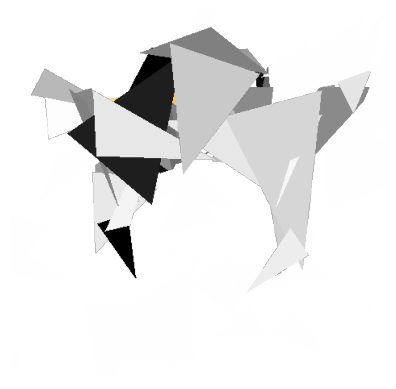

In [4]:
import random
from PIL import Image, ImageDraw
import numpy as np
from skimage.metrics import structural_similarity as ssim
from copy import deepcopy
from sklearn.cluster import KMeans
import cv2

class Color:
    def __init__(self, filename, num_colors=10):
        self.target_image = cv2.imread(filename)
        self.target_image = cv2.cvtColor(self.target_image, cv2.COLOR_BGR2RGB)
        self.height, self.width, _ = self.target_image.shape
        self.palette = self.extract_palette(self.target_image, num_colors).astype(int)
        print("Extracted palette:", self.palette)

    def extract_palette(self, image, num_colors=10):
        pixels = image.reshape((-1, 3))
        kmeans = KMeans(n_clusters=num_colors)
        kmeans.fit(pixels)
        palette = kmeans.cluster_centers_
        return palette

class Triangle:
    def __init__(self, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.palette = palette
        x = random.randint(0, img_width)
        y = random.randint(0, img_height)

        self.points = [
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50))
        ]
        self.color = self._random_color()

    def _random_color(self):
        return tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int)) + (random.randint(0, 256),)

    def mutate(self, mutation_rate=0.01):
        if random.random() < mutation_rate:
            mutation_type = random.choice(['shift', 'point', 'color', 'swap'])
            if mutation_type == 'shift':
                self.points = [(x + random.randint(-50, 50), y + random.randint(-50, 50)) for x, y in self.points]
            elif mutation_type == 'point':
                index = random.choice(range(3))
                self.points[index] = (self.points[index][0] + random.randint(-50, 50), self.points[index][1] + random.randint(-50, 50))
            elif mutation_type == 'color':
                self.color = self._random_color()
            elif mutation_type == 'swap':
                i, j = random.sample(range(3), 2)
                self.points[i], self.points[j] = self.points[j], self.points[i]

class Painting:
    def __init__(self, num_triangles, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.triangles = [Triangle(img_width, img_height, palette) for _ in range(num_triangles)]

    def draw(self) -> Image:
        image = Image.new("RGBA", (self._img_width, self._img_height), (255, 255, 255, 255))
        draw = ImageDraw.Draw(image)
        for t in self.triangles:
            draw.polygon(t.points, fill=t.color)
        return image

    def mutate(self, mutation_rate=0.01):
        for triangle in self.triangles:
            triangle.mutate(mutation_rate)

def calculate_fitness(painting, target_image):
    target_array = np.array(target_image.convert('L'))
    rendered_image = np.array(painting.draw().convert('L'))
    ssim_value = ssim(target_array, rendered_image)
    return 1 - ssim_value

def uniform_crossover(parent1, parent2, crossover_prob=0.5):
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)
    
    for i in range(len(parent1.triangles)):
        if random.random() < crossover_prob:
            child1.triangles[i], child2.triangles[i] = parent2.triangles[i], parent1.triangles[i]
    
    return child1, child2

class Population:
    def __init__(self, size, img_width, img_height, num_triangles, target_image, palette):
        self.size = size
        self.img_width = img_width
        self.img_height = img_height
        self.num_triangles = num_triangles
        self.target_image = target_image
        self.palette = palette
        self.individuals = [Painting(num_triangles, img_width, img_height, palette) for _ in range(size)]
        self.fitness = [calculate_fitness(ind, target_image) for ind in self.individuals]
        self.fitness_history = []

    def evolve(self, gens, xo_prob, mut_prob, elitism):
        for gen in range(gens):
            new_pop = []
            if elitism:
                elite = deepcopy(self.individuals[self.fitness.index(min(self.fitness))])

            while len(new_pop) < self.size:
                parent1 = self.tournament_selection()
                parent2 = self.tournament_selection()

                if random.random() < xo_prob:
                    child1, child2 = uniform_crossover(parent1, parent2)
                else:
                    child1, child2 = deepcopy(parent1), deepcopy(parent2)

                child1.mutate(mut_prob)
                child2.mutate(mut_prob)

                new_pop.extend([child1, child2])

            if elitism:
                worst_index = self.fitness.index(max(self.fitness))
                new_pop[worst_index] = elite

            self.individuals = new_pop[:self.size]
            self.fitness = [calculate_fitness(ind, self.target_image) for ind in self.individuals]
            self.fitness_history.append(min(self.fitness))

            print(f"Generation {gen + 1}, Best Fitness: {min(self.fitness)}")

    def tournament_selection(self, k=3):
        selected = random.sample(list(zip(self.individuals, self.fitness)), k)
        return min(selected, key=lambda x: x[1])[0]

# Parameters
population_size = 50
num_triangles = 100
generations = 500
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True

# File to save fitness values
fitness_file = "fitness_values.txt"

# Run the evolution process 5 times and collect fitness histories
for run in range(1):
    print(f"Run {run + 1}")
    
    # Load target image
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    # Extract palette from target image
    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    # Initialize and evolve population
    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    # Append fitness history for this run to the file
    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")


import matplotlib.pyplot as plt

# Get the best individual
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

# Convert the best individual to an image
best_image = best_individual.draw()

# Convert the image to a format suitable for plt.imshow
best_image_array = np.array(best_image)

# Display the image using Matplotlib
plt.imshow(best_image_array)
plt.axis('off')  # Turn off axis labels
plt.show()

Run 1


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 139   2]
 [ 81  79  77]
 [183 182 182]
 [ 49  36  26]
 [248 195 125]
 [238 232 216]
 [221 139  37]
 [130 130 130]]
Generation 1, Best Fitness: 0.4900100886998725
Generation 2, Best Fitness: 0.4848436376644858
Generation 3, Best Fitness: 0.4595178706177244
Generation 4, Best Fitness: 0.4595178706177244
Generation 5, Best Fitness: 0.4452572232731036
Generation 6, Best Fitness: 0.4452572232731036
Generation 7, Best Fitness: 0.4380939565234512
Generation 8, Best Fitness: 0.428344947379968
Generation 9, Best Fitness: 0.42351343024152566
Generation 10, Best Fitness: 0.4183974114183876
Generation 11, Best Fitness: 0.4181791189043498
Generation 12, Best Fitness: 0.40816231461289876
Generation 13, Best Fitness: 0.4080249457283056
Generation 14, Best Fitness: 0.4041863390882784
Generation 15, Best Fitness: 0.39684256220090175
Generation 16, Best Fitness: 0.39684256220090175
Generation 17, Best Fitness: 0.3886998664109075
Generation 18, Best 

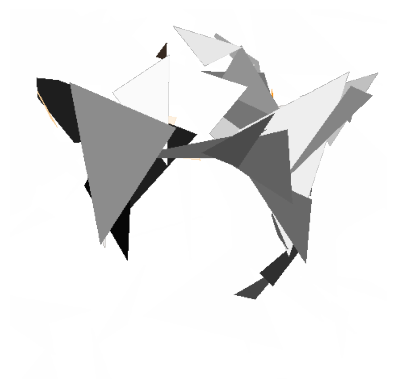

In [5]:
import random
from PIL import Image, ImageDraw
import numpy as np
from skimage.metrics import structural_similarity as ssim
from copy import deepcopy
from sklearn.cluster import KMeans
import cv2

class Color:
    def __init__(self, filename, num_colors=10):
        self.target_image = cv2.imread(filename)
        self.target_image = cv2.cvtColor(self.target_image, cv2.COLOR_BGR2RGB)
        self.height, self.width, _ = self.target_image.shape
        self.palette = self.extract_palette(self.target_image, num_colors).astype(int)
        print("Extracted palette:", self.palette)

    def extract_palette(self, image, num_colors=10):
        pixels = image.reshape((-1, 3))
        kmeans = KMeans(n_clusters=num_colors)
        kmeans.fit(pixels)
        palette = kmeans.cluster_centers_
        return palette

class Triangle:
    def __init__(self, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.palette = palette
        x = random.randint(0, img_width)
        y = random.randint(0, img_height)

        self.points = [
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50))
        ]
        self.color = self._random_color()

    def _random_color(self):
        return tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int)) + (random.randint(0, 256),)

    def mutate(self, mutation_rate=0.01):
        if random.random() < mutation_rate:
            mutation_type = random.choice(['shift', 'point', 'color', 'swap'])
            if mutation_type == 'shift':
                self.points = [(x + random.randint(-50, 50), y + random.randint(-50, 50)) for x, y in self.points]
            elif mutation_type == 'point':
                index = random.choice(range(3))
                self.points[index] = (self.points[index][0] + random.randint(-50, 50), self.points[index][1] + random.randint(-50, 50))
            elif mutation_type == 'color':
                self.color = self._random_color()
            elif mutation_type == 'swap':
                i, j = random.sample(range(3), 2)
                self.points[i], self.points[j] = self.points[j], self.points[i]

class Painting:
    def __init__(self, num_triangles, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.triangles = [Triangle(img_width, img_height, palette) for _ in range(num_triangles)]

    def draw(self) -> Image:
        image = Image.new("RGBA", (self._img_width, self._img_height), (255, 255, 255, 255))
        draw = ImageDraw.Draw(image)
        for t in self.triangles:
            draw.polygon(t.points, fill=t.color)
        return image

    def mutate(self, mutation_rate=0.01):
        for triangle in self.triangles:
            triangle.mutate(mutation_rate)

def calculate_fitness(painting, target_image):
    target_array = np.array(target_image.convert('L'))
    rendered_image = np.array(painting.draw().convert('L'))
    ssim_value = ssim(target_array, rendered_image)
    return 1 - ssim_value

def uniform_crossover(parent1, parent2, crossover_prob=0.5):
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)
    
    for i in range(len(parent1.triangles)):
        if random.random() < crossover_prob:
            child1.triangles[i], child2.triangles[i] = parent2.triangles[i], parent1.triangles[i]
    
    return child1, child2

class Population:
    def __init__(self, size, img_width, img_height, num_triangles, target_image, palette):
        self.size = size
        self.img_width = img_width
        self.img_height = img_height
        self.num_triangles = num_triangles
        self.target_image = target_image
        self.palette = palette
        self.individuals = [Painting(num_triangles, img_width, img_height, palette) for _ in range(size)]
        self.fitness = [calculate_fitness(ind, target_image) for ind in self.individuals]
        self.fitness_history = []

    def evolve(self, gens, xo_prob, mut_prob, elitism):
        for gen in range(gens):
            new_pop = []
            if elitism:
                elite = deepcopy(self.individuals[self.fitness.index(min(self.fitness))])

            while len(new_pop) < self.size:
                parent1 = self.tournament_selection()
                parent2 = self.tournament_selection()

                if random.random() < xo_prob:
                    child1, child2 = uniform_crossover(parent1, parent2)
                else:
                    child1, child2 = deepcopy(parent1), deepcopy(parent2)

                child1.mutate(mut_prob)
                child2.mutate(mut_prob)

                new_pop.extend([child1, child2])

            if elitism:
                worst_index = self.fitness.index(max(self.fitness))
                new_pop[worst_index] = elite

            self.individuals = new_pop[:self.size]
            self.fitness = [calculate_fitness(ind, self.target_image) for ind in self.individuals]
            self.fitness_history.append(min(self.fitness))

            print(f"Generation {gen + 1}, Best Fitness: {min(self.fitness)}")

    def tournament_selection(self, k=3):
        selected = random.sample(list(zip(self.individuals, self.fitness)), k)
        return min(selected, key=lambda x: x[1])[0]

# Parameters
population_size = 50
num_triangles = 100
generations = 500
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True

# File to save fitness values
fitness_file = "fitness_values.txt"

# Run the evolution process 5 times and collect fitness histories
for run in range(1):
    print(f"Run {run + 1}")
    
    # Load target image
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    # Extract palette from target image
    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    # Initialize and evolve population
    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    # Append fitness history for this run to the file
    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")


import matplotlib.pyplot as plt

# Get the best individual
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

# Convert the best individual to an image
best_image = best_individual.draw()

# Convert the image to a format suitable for plt.imshow
best_image_array = np.array(best_image)

# Display the image using Matplotlib
plt.imshow(best_image_array)
plt.axis('off')  # Turn off axis labels
plt.show()

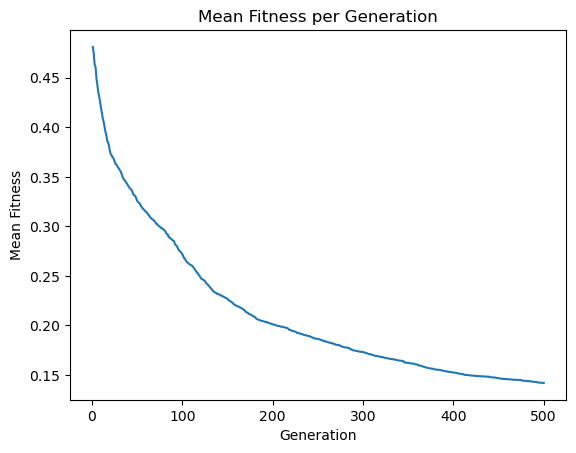

In [6]:
fitness_file = "fitness_values.txt"

with open(fitness_file, "r") as file:
    fitness_values = [float(line.strip()) for line in file]

num_generations_per_run = 500
num_runs = len(fitness_values) // num_generations_per_run

fitness_values = np.array(fitness_values)
fitness_values = fitness_values.reshape(num_runs, num_generations_per_run)

mean_fitness_per_generation = np.mean(fitness_values, axis=0)

plt.plot(range(1, num_generations_per_run + 1), mean_fitness_per_generation)
plt.xlabel('Generation')
plt.ylabel('Mean Fitness')
plt.title('Mean Fitness per Generation')
plt.show()
